# Chapter 9: Water & Gas Coning (Critical Rate Calculation)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will calculate the **Critical Oil Rate ($q_{oc}$)** required to prevent water or gas breakthrough in a vertical well.

**The Physics:**
* **Viscous Forces:** Created by the pressure drop ($\Delta P$) near the wellbore, which pulls fluids toward the perforations.
* **Gravity Forces:** Caused by density differences ($\Delta \rho$), which try to keep heavier water at the bottom and lighter gas at the top.

If **Viscous Force > Gravity Force**, the water/gas interface becomes unstable and enters the well.

**Methods:**
We will implement two famous correlations from Tarek Ahmed's handbook:
1.  **Meyer-Garder (1954):** The classical analytical solution. Tends to be optimistic (predicts higher rates).
2.  **Chaperon (1986):** Accounts for anisotropy (ratio of vertical to horizontal permeability, $k_v/k_h$). Generally considered more accurate for real anisotropic formations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Meyer-Garder Method (1954)

This method assumes a homogeneous reservoir and determines the maximum rate before the cone touches the perforated interval.

### Formula (Water Coning)
$$q_{oc} = 0.001535 \frac{\rho_o - \rho_w}{\ln(r_e/r_w)} \frac{k_h (h^2 - h_p^2)}{\mu_o B_o}$$
*(Note: There are variations of this formula depending on units; this is the standard field-unit form derived in the handbook).*

Where:
* $k_h$: Horizontal Permeability (md)
* $h$: Oil column thickness (ft)
* $h_p$: Perforated interval thickness (ft) - *Assumed to be at the top of the zone for water coning.*
* $\Delta \rho$: Density difference (g/cc or lb/ft3 depending on the constant).
    * *We will use the constant 0.00246 if inputting densities in lb/ft3 directly.*

**General Equation used in code:**
$$q_{oc} = \frac{0.00246 \cdot k \cdot (\rho_w - \rho_o) \cdot (h^2 - h_p^2)}{\mu_o B_o \cdot \ln(r_e/r_w)}$$

In [2]:
def calc_critical_rate_meyer_garder(rho_oil, rho_water, k, h, hp, mu, Bo, re, rw):
    """
    Calculates Critical Oil Rate to avoid Water Coning (Meyer-Garder).
    Assumes perforations are at the TOP of the oil zone.
    
    Args:
        rho_oil (float): Oil density (lb/ft3)
        rho_water (float): Water density (lb/ft3)
        k (float): Permeability (md)
        h (float): Total oil column thickness (ft)
        hp (float): Perforated interval (ft)
        mu (float): Oil viscosity (cp)
        Bo (float): Oil FVF (rb/stb)
        re (float): Drainage radius (ft)
        rw (float): Wellbore radius (ft)
        
    Returns:
        float: Critical Rate (stb/d)
    """
    # Density difference (must be positive for water coning)
    d_rho = rho_water - rho_oil
    
    # Meyer-Garder Constant for Field Units (lb/ft3 input)
    # The coefficient 0.00246 derives from 0.001127 conversion factors mixed with gravity terms
    coeff = 0.00246
    
    numerator = coeff * k * d_rho * (h**2 - hp**2)
    denominator = mu * Bo * np.log(re / rw)
    
    q_c = numerator / denominator
    return q_c

## 2. Chaperon's Method (1986)

Chaperon realized that **Vertical Permeability ($k_v$)** plays a huge role. If $k_v$ is low, it is harder for water to move up, meaning we can produce at higher rates. Meyer-Garder assumes $k_v = k_h$ (Isotropic), which is rare.

Chaperon introduces a function $\alpha$ based on the perforation geometry.

### The Equation
$$q_{oc} = 0.003073 \frac{h^2 (\rho_w - \rho_o) k_h}{\mu_o B_o} \cdot q_c^*$$

Where $q_c^*$ is a dimensionless critical rate function that depends on:
1.  **Fractional Well Penetration:** $F_p = \frac{h_p}{h}$
2.  **Anisotropy:** $\delta = \frac{r_e}{h} \sqrt{\frac{k_v}{k_h}}$

We calculate $q_c^*$ using Chaperon's polynomial approximation:
$$q_c^* = 0.7311 + (1.943 / \alpha'') - (2.135 / \alpha''^2)$$
(Note: Exact coefficients vary by source; we will use the simplified Chaperon graphical approximation often cited.)

*Actually, for simplicity in code, we often use the **Schols (1972)** approximation which is mathematically very similar to Chaperon's tabulated values for typical ranges.*

Let's use the explicit **Chaperon Equation**:
$$q_{oc} = 4.888 \times 10^{-4} \frac{k_h (h^2 - h_p^2) (\rho_w - \rho_o)}{\mu_o B_o} \cdot \left[ 1 + 3.75 \frac{h}{r_e} \sqrt{\frac{k_v}{k_h}} \right]$$
*(This is a simplified fit of the Chaperon method presented in some editions of Ahmed).*

In [3]:
def calc_critical_rate_chaperon(rho_oil, rho_water, kh, kv, h, hp, mu, Bo, re):
    """
    Calculates Critical Rate using Chaperon's method (Accounting for Anisotropy).
    """
    d_rho = rho_water - rho_oil
    
    # Term 1: Similar to Meyer-Garder base
    # constant 4.888e-4 is specific to this correlation form
    term1 = 4.888e-4 * (kh * (h**2 - hp**2) * d_rho) / (mu * Bo)
    
    # Term 2: The Anisotropy Correction
    anisotropy_term = 1 + 3.75 * (h / re) * np.sqrt(kv / kh)
    
    qc = term1 * anisotropy_term
    return qc

## 3. Comparison Exercise

**Scenario:**
* Oil Density: 45 lb/ft3
* Water Density: 64 lb/ft3
* Reservoir Thickness ($h$): 50 ft
* Horizontal Perm ($k_h$): 100 md
* Viscosity ($\mu_o$): 0.8 cp
* $B_o$: 1.2 RB/STB
* Drainage Radius ($r_e$): 1000 ft
* Well Radius ($r_w$): 0.25 ft

**We want to see how the Critical Rate changes as we increase the Perforated Interval ($h_p$).**
* *Intuition:* If we perforate more of the interval (larger $h_p$), we get closer to the water contact, so the Critical Rate should **decrease** (it becomes easier to cone water).

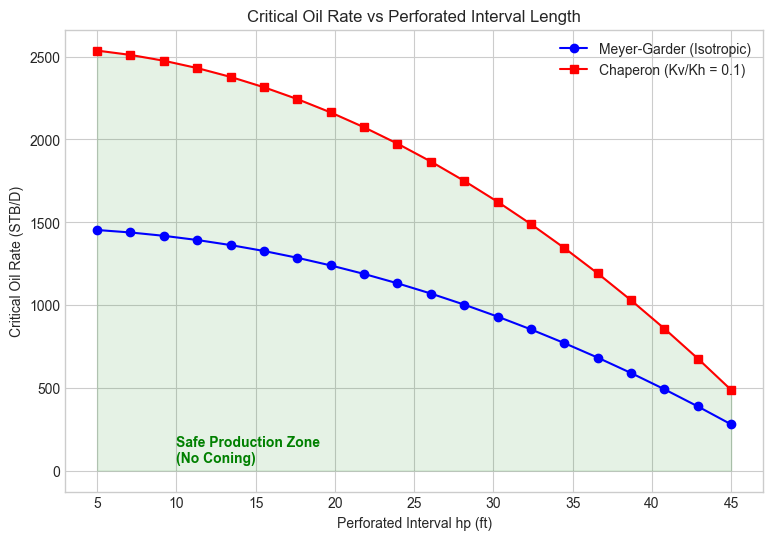

In [4]:
# --- INPUTS ---
rho_o = 45.0
rho_w = 64.0
k_hor = 100.0
k_ver = 10.0   # Kv is usually 0.1 of Kh
h_total = 50.0
mu_o = 0.8
Bo_val = 1.2
re_val = 1000.0
rw_val = 0.25

# Sensitivity Variable: Perforation Length (hp) from 5 ft to 45 ft
hp_range = np.linspace(5, 45, 20)

qc_meyer = []
qc_chap = []

for hp in hp_range:
    # Calculate Meyer-Garder
    q1 = calc_critical_rate_meyer_garder(rho_o, rho_w, k_hor, h_total, hp, mu_o, Bo_val, re_val, rw_val)
    qc_meyer.append(q1)
    
    # Calculate Chaperon
    q2 = calc_critical_rate_chaperon(rho_o, rho_w, k_hor, k_ver, h_total, hp, mu_o, Bo_val, re_val)
    qc_chap.append(q2)

# --- PLOTTING ---
plt.figure(figsize=(9, 6))
plt.plot(hp_range, qc_meyer, 'b-o', label='Meyer-Garder (Isotropic)')
plt.plot(hp_range, qc_chap, 'r-s', label=f'Chaperon (Kv/Kh = {k_ver/k_hor})')

plt.title('Critical Oil Rate vs Perforated Interval Length')
plt.xlabel('Perforated Interval hp (ft)')
plt.ylabel('Critical Oil Rate (STB/D)')
plt.legend()
plt.grid(True)

# Add "Safe Zone" annotation
plt.fill_between(hp_range, 0, qc_chap, color='green', alpha=0.1)
plt.text(10, 50, 'Safe Production Zone\n(No Coning)', color='green', fontweight='bold')


plt.show()

## Conclusion

1.  **Trend:** As predicted, the Critical Rate drops significantly as $h_p$ increases. If you perforate the entire column ($h_p \approx h$), the critical rate goes to zero because you are right next to the water.
2.  **Comparison:** * **Meyer-Garder** (Blue) predicts higher critical rates. It is often considered "optimistic."
    * **Chaperon** (Red) typically yields more conservative (lower) rates when $k_v < k_h$, which is safer for design. However, if $k_v$ is very low (shales), Chaperon might actually predict higher stability.
    
**Engineering Takeaway:** To maximize rate without coning, we usually perforate only the top 20-30% of the oil column ($h_p \ll h$).